In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [2]:
# we create 40 separable points
random_state = 2**3
x, y = make_blobs(n_samples=40, centers=2, random_state=random_state)

In [3]:
# fit the model, don't regularize for illustration purposes
model = svm.SVC(kernel='linear', C=1000)
model.fit(x, y)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [4]:
x_min = x[:, 0].min() * 1.2
x_max = x[:, 0].max() * 1.2
y_min = x[:, 1].min() * 1.2
y_max = x[:, 1].max() * 1.2

w = model.coef_[0]
print('coef_', w)
a = -w[0] / w[1]
xx = np.linspace(x_min, x_max)
yy = a * xx - (model.intercept_[0]) / w[1]
print('intercept_', model.intercept_)
print(xx)
print(yy)

margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

coef_ [ 0.03245504 -0.35268672]
intercept_ [1.636684]
[ 5.09876524  5.23609008  5.37341491  5.51073975  5.64806458  5.78538942
  5.92271425  6.06003909  6.19736392  6.33468875  6.47201359  6.60933842
  6.74666326  6.88398809  7.02131293  7.15863776  7.2959626   7.43328743
  7.57061227  7.7079371   7.84526193  7.98258677  8.1199116   8.25723644
  8.39456127  8.53188611  8.66921094  8.80653578  8.94386061  9.08118544
  9.21851028  9.35583511  9.49315995  9.63048478  9.76780962  9.90513445
 10.04245929 10.17978412 10.31710896 10.45443379 10.59175862 10.72908346
 10.86640829 11.00373313 11.14105796 11.2783828  11.41570763 11.55303247
 11.6903573  11.82768213]
[5.10981702 5.12245397 5.13509092 5.14772786 5.16036481 5.17300175
 5.1856387  5.19827564 5.21091259 5.22354953 5.23618648 5.24882343
 5.26146037 5.27409732 5.28673426 5.29937121 5.31200815 5.3246451
 5.33728204 5.34991899 5.36255593 5.37519288 5.38782983 5.40046677
 5.41310372 5.42574066 5.43837761 5.45101455 5.4636515  5.47628844
 5

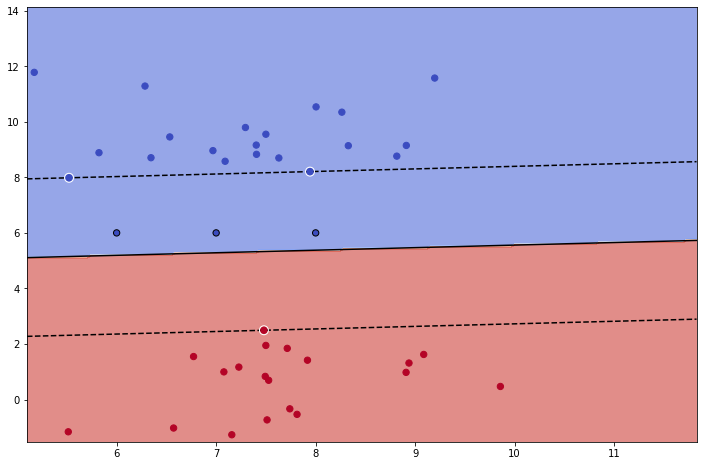

In [5]:
XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

figsize = np.array(plt.rcParams["figure.figsize"]) * 2
plt.figure(figsize=figsize.tolist())

plt.contourf(XX, YY, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='white')
plt.scatter(x[:, 0], x[:, 1], c=y, zorder=10, cmap='coolwarm', edgecolor='face', s=40)

x_test = np.array([[6.0, 6.0], [7.0, 6.0], [8.0, 6.0]])
pred_test = model.predict(x_test)
plt.scatter(x_test[:, 0], x_test[:, 1], c=pred_test, zorder=10, cmap='coolwarm', edgecolor='k', s=40)

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [6]:
model.support_vectors_


array([[5.52161775, 7.98446372],
       [7.94310647, 8.20622208],
       [7.48006237, 2.49392925]])

In [7]:
model.dual_coef_


array([[-0.0253979 , -0.03732979,  0.06272769]])

In [10]:
model._


0.0

In [9]:
model.predict([[6.0, -6.0]])

array([1])

## Some links
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/svm.html

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html

https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html

https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html


In [15]:
print(np.exp(2+2))
print(np.exp(2)*np.exp(2))

54.598150033144236
54.59815003314424
